In [2]:


HIVE_HOST = 'ds-hadoop-cs01p'
HIVE_PORT = 10000
HIVE_USER = 'osminink'
CONF={'hive.vectorized.execution.enabled':'true'
    ,'mapreduce.map.memory.mb':'4096'
    ,'mapreduce.map.child.java.opts':'-Xmx4g'
    ,'mapreduce.task.io.sort.mb':'1024'
    ,'mapreduce.reduce.child.java.opts':'-Xmx4g'
    ,'mapreduce.reduce.memory.mb':'7000'
    ,'mapreduce.reduce.shuffle.input.buffer.percent':'0.5'
    ,'mapreduce.input.fileinputformat.split.minsize':'536870912'
    ,'mapreduce.input.fileinputformat.split.maxsize':'1073741824'
    ,'hive.optimize.ppd':'true'
    ,'hive.merge.smallfiles.avgsize':'536870912'
    ,'hive.merge.mapredfiles':'true'
    ,'hive.merge.mapfiles':'true'
    ,'hive.hadoop.supports.splittable.combineinputformat':'true'
    ,'hive.exec.reducers.bytes.per.reducer':'536870912'
    ,'hive.exec.parallel':'true'
    ,'hive.exec.max.created.files':'10000000'
    ,'hive.exec.compress.output':'true'
    ,'hive.exec.dynamic.partition.mode':'nonstrict'
    ,'hive.exec.max.dynamic.partitions':'1000000'
    ,'hive.exec.max.dynamic.partitions.pernode':'100000'
    ,'io.seqfile.compression.type':'BLOCK'
          }

from pyhive import hive
conn = hive.Connection(host=HIVE_HOST, port=HIVE_PORT, username=HIVE_USER, configuration=CONF)
cursor = conn.cursor()


In [1]:
from pyspark import SparkConf, SparkContext, HiveContext
from pyspark.sql import Row
sc.stop()
conf = SparkConf().set("spark.executor.instances", 32).set("spark.driver.maxResultSize", "4g")
sc = SparkContext(conf=conf)

In [3]:
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import sklearn
import sklearn.ensemble
import numpy as np
import pandas as pd
import datetime


In [1]:
train = sc.textFile("/user/amelnikov/data/cold_calls_cc/train.csv")
test = sc.textFile("/user/amelnikov/data/cold_calls_cc/test.csv")

In [2]:
train.filter(lambda r: '89133849511' in r).collect()

[u'89133849511;01APR2016:17:58:50.000000;1;1;0;\u0423\u0441\u043f\u0435\u0448\u043d\u043e;26AUG1956;0']

Успешно


In [5]:
header_train = train.first()
header_test = test.first()

def handle_date(dt_str):
    try:
        return (1, datetime.datetime.strptime(dt_str,"%d%b%Y"))
    except ValueError:
        return (0, dt_str)

def handle_dt(dt_str):
    try:
        return (1, datetime.datetime.strptime(dt_str,"%d%b%Y:%H:%M:%S.%f"))
    except ValueError:
        return (0, dt_str)

t1 = train \
     .filter(lambda r: r!= header_train) \
     .map(lambda r: r.split(';')) \
     .map(lambda r: (r[0],) + handle_dt(r[1]) + (int(r[2]),int(r[3]),int(r[4]),r[5]) + handle_date(r[6]) + (int(r[7]),)) \
     .map(lambda r: (r[2].date(),) + r)
#t1.cache()

#header_train = train.first()
#train = train.filter(lambda r: r!= header_train).map(lambda r: Row(*header_train.split(';'))(*r.split(';')))

In [175]:
#status_count = t1.map(lambda r : r[7]).groupBy(lambda r:r).map(lambda r: (r[0],len(r[1]))).collect()
status_stat = t1.map(lambda r: (r[7],(r[4],r[5],r[6],r[10],1))).reduceByKey(lambda x,y: tuple(sum(z) for z in zip(x,y))).collect()

print('  full_app    approve    util_30  stop_cond      count             status\n'+ \
      '\n'.join([
            '{0:>10} {1:>10} {2:>10} {3:>10} {4:>10}   '.format(*e[1]) + e[0]
        for e in sorted(status_stat,key = lambda e:-e[1][4])]))

  full_app    approve    util_30  stop_cond      count             status
         0          0          0          0    2502097   Нет потребности в кредите
        10          2          0          1    2085578   Недозвон
         4          2          1          0    1117242   Не требуется сейчас
         2          0          0          1     734276   Попросил не звонить/Претензионный
         0          0          0          0     646545   Кредит / КК в другом банке
    482054     265085      68479      89706     482884   Успешно
         0          0          0          0     441979   Не отвечает
         2          1          0          1     350600   Другое (нестандартная ситуация)
         4          1          0          1     337347   Левый контакт
         2          1          1          0     142827   Перезвонит самостоятельно позднее
         1          0          0          0     106901   Не устраивают условия
         0          0          0          0      69390   Заня

In [186]:
ymd_stat = t1.map(lambda r: (r[0],(r[4],r[5],r[6],r[10],1))).reduceByKey(lambda x,y: tuple(sum(z) for z in zip(x,y))).collect()

print('      ymd       full_app    approve    util_30  stop_cond      count\n'+ \
      '\n'.join([
            '{0:}    {1:>10} {2:>10} {3:>10} {4:>10} {5:>10} '.format(str(e[0]),*e[1])
        for e in sorted(ymd_stat,key = lambda e:e[0])]))

      ymd       full_app    approve    util_30  stop_cond      count
2016-01-01             0          0          0          0          6 
2016-01-02           182        116         19         23       3500 
2016-01-03           587        362         92         92      11997 
2016-01-04           954        604        167        151      18489 
2016-01-05          1322        846        206        165      23495 
2016-01-06          1207        813        188        160      21469 
2016-01-07           997        614        157        140      17446 
2016-01-08          1249        826        176        157      23175 
2016-01-09          1142        715        187        172      21715 
2016-01-10          1163        774        176        157      19483 
2016-01-11           998        625        155        162      19009 
2016-01-12           173        107         28         28       4933 
2016-01-13          1064        691        168        157      20868 
2016-01-14           

In [196]:
dfy = pd.DataFrame((((e[0],)+e[1]) for e in ymd_stat),columns = 'ymd full_app approve util_30 stop_cond count'.split(' ')) \
    .set_index('ymd').sort()

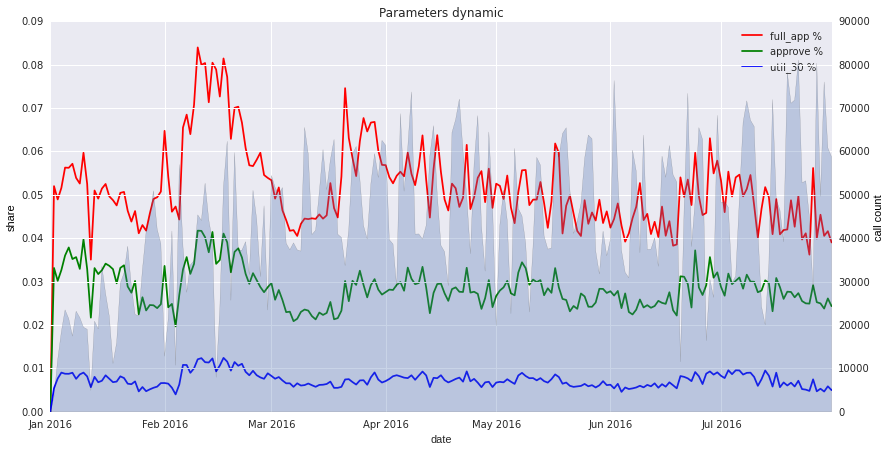

In [307]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

#plt.plot(dfy.index,dfy['full_app']/dfy['count'],label = 'full_app %')
#plt.plot(dfy.index,dfy['approve']/dfy['count'],label = 'full_app %')
#plt.plot(dfy.index,dfy['util_30']/dfy['count'],label = 'full_app %')
#plt.bar(dfy.index,dfy['count'],label = 'call count', linewidth = 0,)

fig, ax1 = plt.subplots()
fig.set_size_inches(14, 7)
ax2 = ax1.twinx()
ax2.fill_between(dfy.index, 0, dfy['count'],alpha=0.3)
ax1.plot(dfy.index,dfy['full_app']/dfy['count'],'r',label = 'full_app %')
ax1.plot(dfy.index,dfy['approve']/dfy['count'],'g',label = 'approve %')
ax1.plot(dfy.index,dfy['util_30']/dfy['count'],'b',label = 'util_30 %')
#ax2.plot(dfy.index,dfy['count'],'black',label = 'call count')


ax1.set_xlabel('date')
ax1.set_ylabel('share', color='black')
ax2.set_ylabel('call count', color='black')
ax1.legend()
#ax2.legend()
plt.legend()
plt.title('Parameters dynamic')
plt.show()

#dfy.apply(lambda r: pd.Series([float(r[0])/r[4],float(r[1])/r[4],float(r[2])/r[4]]),axis = 1).plot()

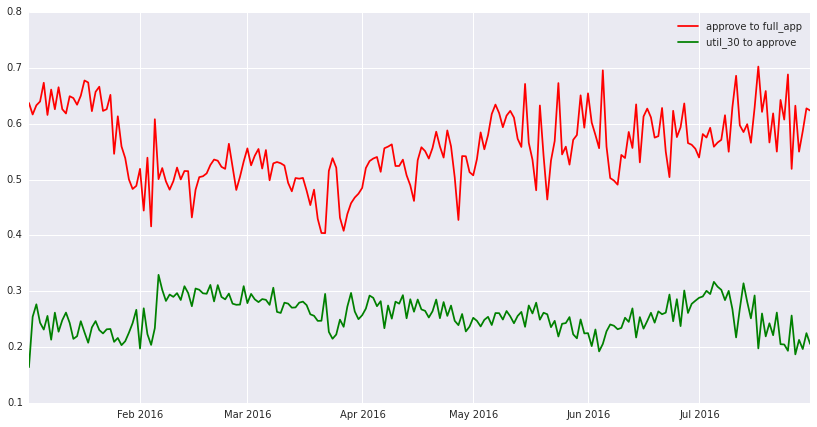

In [246]:

fig, ax1 = plt.subplots()
fig.set_size_inches(14, 7)
ax1.plot(dfy.index,dfy['approve']/dfy['full_app'],'r',label = 'approve to full_app')
ax1.plot(dfy.index,dfy['util_30']/dfy['approve'],'g',label = 'util_30 to approve')
plt.legend()
plt.show()

In [294]:
check_phone_nums = t1 \
     .map(lambda r:r[1]) \
     .map(lambda n: (n[0] == '8',not re.match('[0-9]{11}',n) is None,n[0:2] == '+7',1)) \
     .reduce(lambda x,y: tuple(sum(z) for z in zip(x,y)))
print(('\nPhone numbers count:\nStarting from 8:    {0}\nIn 11 digit format: {1}\n'+ \
      'Starting from +7:   {2}\nTotal:              {3}\n').format(*check_phone_nums)) 


Phone numbers count:
Starting from 8:    9390194
In 11 digit format: 9390194
Starting from +7:   0
Total:              9390194



** Все телефоны в 11-значном формате, только цифры и начинаются с 8. **

In [9]:
hc = HiveContext(sc)
hc.sql('drop table if exists cold_calls_tmp')
hc.registerDataFrameAsTable(hc.createDataFrame(t1.map(lambda r:(r[0:7]+(r[10],r[7])))), 'cold_calls_tmp')
hc.sql('drop table if exists user_kposminin.cold_calls_2')
create_query = '''
create table user_kposminin.cold_calls_4 as 
select 
    `_1` as ymd,
    `_2` as phone_num,
    `_3` as is_dt,
    `_4` as dt,
    `_5` as full_app,
    `_6` as approve,
    `_7` as util_30,
    `_8` as stop_cond,
    `_9` as status
from cold_calls_tmp
'''
hc.sql(create_query)

DataFrame[]

In [13]:
a = hc.createDataFrame(t1.map(lambda r:(r[0:7]+r[8:])))

In [22]:
a.filter(a._8!=0).take(3)

[Row(_1=datetime.date(2016, 4, 9), _2=u'89094026396', _3=1, _4=datetime.datetime(2016, 4, 9, 16, 21, 58), _5=1, _6=1, _7=0, _8=1, _9=u'java.util.GregorianCalendar[time=?,areFieldsSet=false,areAllFieldsSet=false,lenient=true,zone=sun.util.calendar.ZoneInfo[id="W-SU",offset=10800000,dstSavings=0,useDaylight=false,transitions=79,lastRule=null],firstDayOfWeek=1,minimalDaysInFirstWeek=1,ERA=?,YEAR=1974,MONTH=6,WEEK_OF_YEAR=?,WEEK_OF_MONTH=?,DAY_OF_MONTH=27,DAY_OF_YEAR=?,DAY_OF_WEEK=?,DAY_OF_WEEK_IN_MONTH=?,AM_PM=0,HOUR=0,HOUR_OF_DAY=0,MINUTE=0,SECOND=0,MILLISECOND=0,ZONE_OFFSET=?,DST_OFFSET=?]', _10=0),
 Row(_1=datetime.date(2016, 2, 10), _2=u'89871114998', _3=1, _4=datetime.datetime(2016, 2, 10, 20, 25, 36), _5=1, _6=1, _7=0, _8=1, _9=u'java.util.GregorianCalendar[time=?,areFieldsSet=false,areAllFieldsSet=false,lenient=true,zone=sun.util.calendar.ZoneInfo[id="W-SU",offset=10800000,dstSavings=0,useDaylight=false,transitions=79,lastRule=null],firstDayOfWeek=1,minimalDaysInFirstWeek=1,ERA=?,Y

In [33]:
#b = hc.createDataFrame(t1.map(lambda r:(r[0:7]+(r[8],(r[9].date() if r[8] == 1 else r[9]),r[10]))))
d = b.take(30000)

In [38]:
[e for e in d if e._8!=0][0]._9

u'java.util.GregorianCalendar[time=?,areFieldsSet=false,areAllFieldsSet=false,lenient=true,zone=sun.util.calendar.ZoneInfo[id="W-SU",offset=10800000,dstSavings=0,useDaylight=false,transitions=79,lastRule=null],firstDayOfWeek=1,minimalDaysInFirstWeek=1,ERA=?,YEAR=1974,MONTH=6,WEEK_OF_YEAR=?,WEEK_OF_MONTH=?,DAY_OF_MONTH=27,DAY_OF_YEAR=?,DAY_OF_WEEK=?,DAY_OF_WEEK_IN_MONTH=?,AM_PM=0,HOUR=0,HOUR_OF_DAY=0,MINUTE=0,SECOND=0,MILLISECOND=?,ZONE_OFFSET=?,DST_OFFSET=?]'

In [44]:
t2 = t1.map(lambda r:(r[0:7]+r[8:])).filter(lambda row:row[7]!=0)

In [49]:
t2 = t1.map(lambda r:r[9].date() if r[8] == 1 else r[9])

In [51]:
t2.count()

9390194

In [52]:
sc.stop()

In [1]:

another_test_prepare_query = '''
insert overwrite table user_kposminin.phone_id_test partition (ymd) 
  select     
    m.phone_num,
    m.id,
    if(ua.id is Null,0,1) as approve_label,
    if(uf.id is Null,0,1) as full_app_label,
    nvl(uf.first_day,0) as full_app_first_day,
    m.sampled,
    if(substr(md5(concat(phone_num,'aa')),1,1) = '0', 1, 0) as strong_sampled,
    '#ymd0' as ymd
  from
    (select 
       uid_str as id,
       property_value as phone_num,
       if(substr(md5(property_value),1,1) = '0', 1, 0) as sampled
     from
       prod_dds.md_uid_property 
     where
       property_cd = 'PHONE' and
       load_src = 'LI.02' and
       md5(property_value),1,1) = '0'
    ) m
    left semi join prod_raw_liveinternet.access_log v on u.id = v.id 
    left join(
      select distinct id, if(ymd = '#ymd1',1,0) as first_day
      from prod_features_liveinternet.user_action
      where action_type = 'tinkoff_platinum_approved_application'
        and ymd between '#ymd1' and '#ymd3'
    ) ua on ua.id = m.id
    left join(
      select distinct id, if(ymd = '#ymd1',1,0) as first_day
      from prod_features_liveinternet.user_action
      where action_type = 'tinkoff_platinum_complete_application'
        and ymd between '#ymd1' and '#ymd3'
    ) uf on uf.id = m.id
    where
      (sampled = 1 and v.ymd = '#ymd0')
;



insert overwrite table user_kposminin.url_text_test partition (ymd) 
select 
  u.phone_num,
  max(u.approve_label) as approve_label,
  max(u.full_app_label) as full_app_label,
  max(u.full_app_first_day) as full_app_first_day,
  max(u.sampled) as sampled,
  max(u.strong_sampled) as strong_sampled,
  concat_ws(' ',collect_list(url)) as up,
  '#ymd0' as ymd
from 
  user_kposminin.phone_id_test u
  inner join prod_raw_liveinternet.access_log v on u.id = v.id 
where
  u.ymd = '#ymd0' and 
  v.ymd = '#ymd0'
group by 
  u.phone_num
;



'''
import datetime

test_date = datetime.datetime(2017,1,17).date()
qq = ''
for _ in range(1):
    query = another_test_prepare_query.replace('#ymd0',str(test_date)) \
      .replace('#ymd1',str(test_date + datetime.timedelta(days = 1))) \
      .replace('#ymd3',str(test_date + datetime.timedelta(days = 3))) \
      .replace('#ind',str(test_date).replace('-',''))
    qq += query
    #test_date = test_date - datetime.timedelta(days = 2)
print(qq)


insert overwrite table user_kposminin.phone_id_test partition (ymd) 
  select     
    m.phone_num,
    m.id,
    if(ua.id is Null,0,1) as approve_label,
    if(uf.id is Null,0,1) as full_app_label,
    nvl(uf.first_day,0) as full_app_first_day,
    m.sampled,
    if(substr(md5(concat(phone_num,'aa')),1,1) = '0', 1, 0) as strong_sampled,
    '2017-01-17' as ymd
  from
    (select 
       uid_str as id,
       property_value as phone_num,
       if(substr(md5(property_value),1,1) = '0', 1, 0) as sampled
     from
       prod_dds.md_uid_property 
     where
       property_cd = 'PHONE' and
       load_src = 'LI.02' and
       md5(property_value),1,1) = '0'
    ) m
    left semi join prod_raw_liveinternet.access_log v on u.id = v.id 
    left join(
      select distinct id, if(ymd = '2017-01-18',1,0) as first_day
      from prod_features_liveinternet.user_action
      where action_type = 'tinkoff_platinum_approved_application'
        and ymd between '2017-01-18' and '2017-01-20'
    ) u